In [1]:
import numpy as np
import json
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
activation = [
    'relu',
    'sigmoid',
    'linear',
    'softmax',
]

In [3]:
class ActivationFunction:
    def __init__(self, activation_function):
        if activation_function == 'sigmoid':
            self.function = lambda net: 1 / (1 + np.exp(-net))
        elif activation_function == 'relu':
            self.function = lambda net: np.maximum(0, net)
        elif activation_function == 'linear':
            self.function = lambda net: net
        elif activation_function == 'softmax':
            self.function = lambda net: np.exp(net) / np.sum(np.exp(net))

    def get_activation_function(self):
        return self.function

In [4]:
class Layer:
    def __init__(self, neuron: int, activation_function: str, weights: np.array, bias: np.array):
        self.neuron = neuron
        self.weights = weights
        self.bias = bias
        if activation_function not in activation:
            raise Exception('Invalid activation function')
        else:
            self.activation_function = activation_function
            self.function = ActivationFunction(activation_function).get_activation_function()

    def forward(self, input: np.array):
        output = self.function(np.dot(input, self.weights) + self.bias)
        return np.round(output, decimals=7)

In [5]:
class FFNN:
    def __init__(self):
        self.layers = []
        self.node_bobots = []

    def add_layer(self, layer: Layer):
        self.layers.append(layer)

    def forward(self, input: np.array):
        output = input

        self.node_bobots.append(output[0])
        for layer in self.layers:
            output = layer.forward(output)
            temp_nodes = output[0].tolist()
            self.node_bobots.append(temp_nodes)
        return output

In [6]:
class NeuralNetworkGraph:
    def __init__(self):
        self.graphs = nx.DiGraph()
        self.node_labels = {}

    def add_nodes_layer(self, nodes, layer):
        self.graphs.add_nodes_from(nodes, layer=layer)

    def add_edge(self, node_source, node_goal):
        self.graphs.add_edge(node_source, node_goal)

    def add_all_nodes(self, node_bobots):

        # Add input bias label
        self.node_labels[0] = "Input"+str(0)+": "+str(1)

        node_number = 1

        self.add_nodes_layer([i for i in range(len(node_bobots[0])+1)], 0)

        # Add input label
        for i, node_value in enumerate(node_bobots[0]):
            self.node_labels[node_number] = "Input"+str(i+1)+": "+str(node_value)
            node_number += 1

        # Add nodes for each layer with the subset key
        for i in range(1, len(node_bobots)-1):
            self.node_labels[node_number] = "H"+str(i)+str(0)+": "+str(1)
            self.add_nodes_layer([node_number+j for j in range(len(node_bobots[i])+1)], i)
            node_number += 1
            for j in range(len(node_bobots[i])):
                self.node_labels[node_number] = "H"+str(i)+str(j+1)+": "+str(node_bobots[i][j])
                node_number += 1

        self.add_nodes_layer([node_number+j for j in range(len(node_bobots[-1]))], len(node_bobots))

        # Add output nodes
        for i, node_value in enumerate(node_bobots[-1]):
            self.node_labels[node_number] = "Output"+str(i+1)+": "+str(node_value)
            node_number += 1

    def add_all_edges(self, node_bobots):
        number_of_prev_neuron = 0
        curr_number_neuron = 0

        # Add edge for each node of input layer and hidden layer
        for layer_number in range(len(node_bobots)-2):
            curr_number_neuron += len(node_bobots[layer_number])+1
            for i in range(len(node_bobots[layer_number])+1):
                for j in range(len(node_bobots[layer_number+1])):
                    self.add_edge(number_of_prev_neuron, curr_number_neuron+j+1)
                number_of_prev_neuron += 1

        # Add edge for each node on output layer
        curr_number_neuron += len(node_bobots[-2])+1
        for i in range(len(node_bobots[-2])+1):
            for j in range(len(node_bobots[-1])):
                self.add_edge(number_of_prev_neuron, curr_number_neuron+j)
            number_of_prev_neuron += 1
        
        

In [7]:
# for saving the model
def saveModel(weights, layers, fileName):
    case_dict = {'case': {'weights': weights, 'model': {'layers': layers}}}
    with open(f"../../Bagian-A/model/{fileName}_latest_weights_and_structures.json", 'w') as outfile:
        json.dump(case_dict, outfile, indent=4)

In [8]:
# for visualizing the model
def visualizeModel(ffnn, weights):
    # Initialize a directed graph for visualization
    neural_network_graph = NeuralNetworkGraph()

    neural_network_graph.add_all_nodes(ffnn.node_bobots)

    neural_network_graph.add_all_edges(ffnn.node_bobots)

    # Assuming neural_network_graph.graphs is your graph object
    neural_network_graphs = neural_network_graph.graphs  # Assuming this is a correct reference

    # Add 'layer' attribute to nodes if it's missing
    for node in neural_network_graphs.nodes():
        if 'layer' not in neural_network_graphs.nodes[node]:
            neural_network_graphs.nodes[node]['layer'] = 0  # Set a default layer if needed

    # Plot the neural network structure
    pos = nx.multipartite_layout(neural_network_graphs, subset_key="layer", align='horizontal')
    nx.draw(neural_network_graphs, pos, with_labels=True, labels=neural_network_graph.node_labels, node_size=2000, node_color="lightblue", font_size=7, font_weight="bold")

    # Add edge labels for better understanding
    edge_labels = {}
    index = 0
    sub_index = 0
    sub_sub_index = 0
    for u, v in neural_network_graphs.edges():
        edge_labels[(u,v)] = weights[index][sub_index][sub_sub_index]
        if(sub_sub_index+1<len(weights[index][sub_index])):
            sub_sub_index += 1
        else:
            sub_sub_index = 0
            if(sub_index+1<len(weights[index])):
                sub_index += 1
            else:
                sub_index = 0
                index += 1
    print("Edge labels: ",edge_labels)
    nx.draw_networkx_edge_labels(neural_network_graphs, pos, edge_labels=edge_labels, font_size=7, font_color='red')

    plt.title("Neural Network Structure (Input to Output)")
    plt.axis('off')
    plt.show()

In [9]:
# without using saved model (contains weights and structure)
def calculateWithoutSavedModel(fileName):
    model = open(f'../../Bagian-A/test/{fileName}.json', 'r')
    model = json.load(model)

    layers = model['case']['model']['layers']
    weights = model['case']['weights']

    # for saving model
    layers_dict = []
    weights_dict = []

    ffnn = FFNN()
    for i in range (len(layers)):
        layer = layers[i]
        weight = weights[i]

        # add the layers and weights
        layers_dict.append(layer)
        weights_dict.append(weight)

        ffnn.add_layer(Layer(layer["number_of_neurons"], layer["activation_function"], np.array(weight[1:]), np.array(weight[0])))

    saveModel(weights_dict, layers_dict, fileName) # save the model

    input = model["case"]["input"]

    output = ffnn.forward(input).tolist()
    expected_output = model['expect']['output']

    print("Node values: ", ffnn.node_bobots)

    print(f'output: {output}')
    print(f'expected output: {expected_output}')

    visualizeModel(ffnn, weights)

In [10]:
# with saved model
def calculateWithSavedModel(fileName):
    model = open(f'../../Bagian-A/test/{fileName}.json', 'r')
    model = json.load(model)

    # loading the saved models (it contains the layers and weights)
    savedModel = open(f'../../Bagian-A/model/{fileName}_latest_weights_and_structures.json', 'r')
    savedModel = json.load(savedModel)

    layers = savedModel['case']['model']['layers']
    weights = savedModel['case']['weights']

    ffnn = FFNN()
    for i in range (len(layers)):
        layer = layers[i]
        weight = weights[i]
        ffnn.add_layer(Layer(layer["number_of_neurons"], layer["activation_function"], np.array(weight[1:]), np.array(weight[0])))


    input = model["case"]["input"]

    output = ffnn.forward(input).tolist()
    expected_output = model['expect']['output']

    print("Node values: ", ffnn.node_bobots)

    print(f'output: {output}')
    print(f'expected output: {expected_output}')

    visualizeModel(ffnn, weights)

CALCULATIONS

    LINEAR

Node values:  [[-4.0], [-11.0]]
output: [[-11.0], [-8.0], [-5.0], [-2.0], [1.0], [4.0], [7.0], [10.0], [13.0], [16.0]]
expected output: [[-11], [-8], [-5], [-2], [1], [4], [7], [10], [13], [16]]
Edge labels:  {(0, 2): 1.0, (1, 2): 3.0}


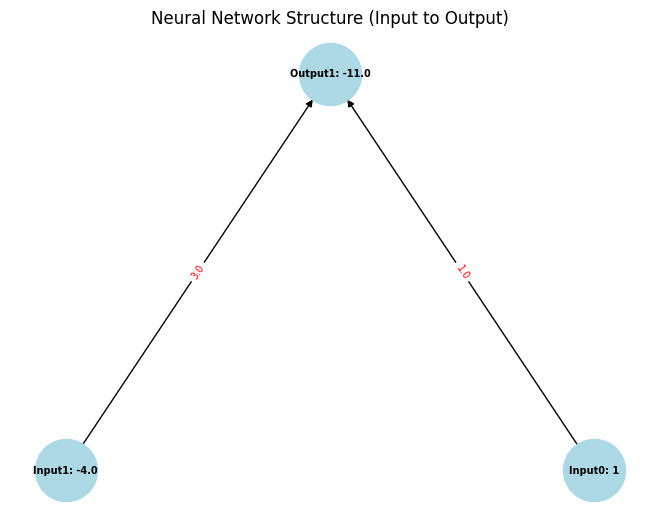

In [11]:
calculateWithoutSavedModel("linear")

    MULTILAYER SOFTMAX

Node values:  [[0.1, -0.8, 1, 1.2], [0.64, 0.0, 1.53, 0.0], [2.45, 0.0, 2.356, 0.0], [0.0, 1.0772, 0.0, 1.008], [0.7042294, 0.2957706]]
output: [[0.7042294, 0.2957706]]
expected output: [[0.7042294, 0.2957706]]
Edge labels:  {(0, 6): -0.9, (0, 7): 1.2, (0, 8): -0.6, (0, 9): 0.3, (1, 6): 0.8, (1, 7): -0.7, (1, 8): 1.1, (1, 9): -1.2, (2, 6): 0.3, (2, 7): -1.4, (2, 8): 0.7, (2, 9): 1.2, (3, 6): 1.1, (3, 7): -1.3, (3, 8): 0.9, (3, 9): 0.4, (4, 6): 0.5, (4, 7): -0.8, (4, 8): 1.4, (4, 9): -0.9, (5, 11): 0.7, (5, 12): -1.1, (5, 13): 0.2, (5, 14): -1.4, (6, 11): 1.3, (6, 12): -0.6, (6, 13): 0.5, (6, 14): -1.3, (7, 11): -1.2, (7, 12): 0.9, (7, 13): 1.4, (7, 14): -0.7, (8, 11): 0.6, (8, 12): -0.5, (8, 13): 1.2, (8, 14): -1.1, (9, 11): 1.0, (9, 12): -0.4, (9, 13): 0.8, (9, 14): -1.0, (10, 16): -1.3, (10, 17): 0.7, (10, 18): -0.8, (10, 19): 1.3, (11, 16): 0.2, (11, 17): -1.0, (11, 18): 1.1, (11, 19): -0.6, (12, 16): 1.4, (12, 17): -0.9, (12, 18): 0.3, (12, 19): -1.4, (13, 16): -0.7, (13, 17): 1.2,

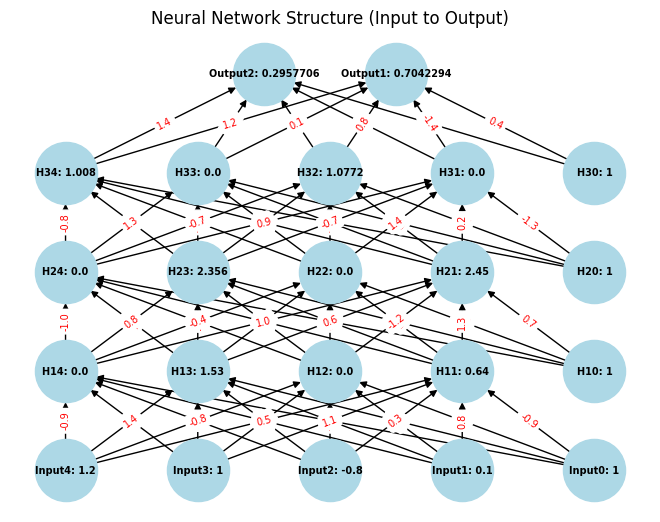

In [12]:
calculateWithoutSavedModel("multilayer_softmax")

    MULTILAYER

Node values:  [[-1.0, 0.5, 0.8], [2.09, 1.22, 0.25, 0.0], [0.168, 1.708, 0.556], [1.13, 0.2156], [0.4846748]]
output: [[0.4846748]]
expected output: [[0.4846748]]
Edge labels:  {(0, 5): 0.1, (0, 6): 0.2, (0, 7): 0.3, (0, 8): -1.2, (1, 5): -0.5, (1, 6): 0.6, (1, 7): 0.7, (1, 8): 0.5, (2, 5): 0.9, (2, 6): 1.0, (2, 7): -1.1, (2, 8): -1.0, (3, 5): 1.3, (3, 6): 1.4, (3, 7): 1.5, (3, 8): 0.1, (4, 10): 0.1, (4, 11): 0.1, (4, 12): 0.3, (5, 10): -0.4, (5, 11): 0.5, (5, 12): 0.6, (6, 10): 0.7, (6, 11): 0.4, (6, 12): -0.9, (7, 10): 0.2, (7, 11): 0.3, (7, 12): 0.4, (8, 10): -0.1, (8, 11): 0.2, (8, 12): 0.1, (9, 14): 0.1, (9, 15): 0.2, (10, 14): -0.3, (10, 15): 0.4, (11, 14): 0.6, (11, 15): 0.1, (12, 14): 0.1, (12, 15): -0.4, (13, 16): 0.1, (14, 16): -0.2, (15, 16): 0.3}


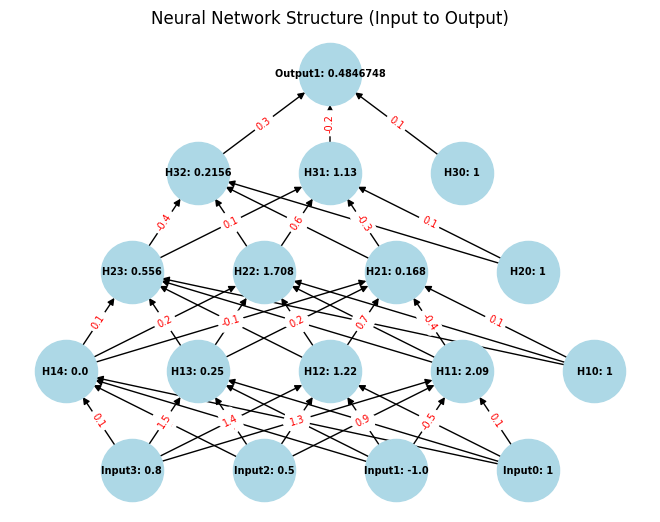

In [13]:
calculateWithoutSavedModel("multilayer")

    RELU

Node values:  [[-1.0, 0.5], [0.05, 1.1, 0.0]]
output: [[0.05, 1.1, 0.0]]
expected output: [[0.05, 1.1, 0.0]]
Edge labels:  {(0, 3): 0.1, (0, 4): 0.2, (0, 5): 0.3, (1, 3): 0.4, (1, 4): -0.5, (1, 5): 0.6, (2, 3): 0.7, (2, 4): 0.8, (2, 5): -0.9}


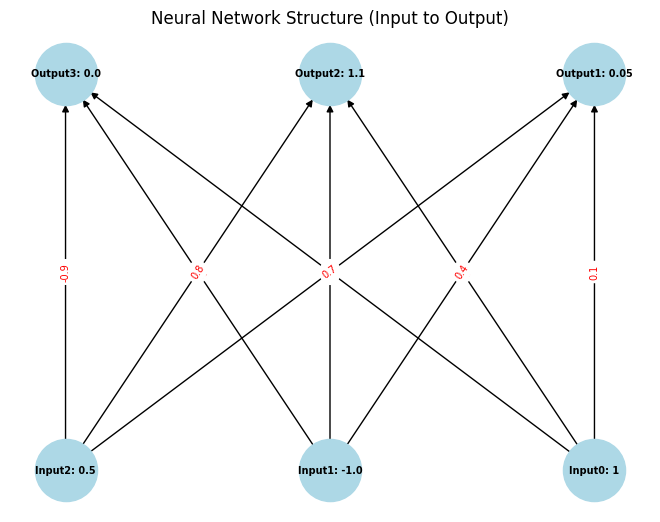

In [14]:
calculateWithoutSavedModel("relu")

    SIGMOID

Node values:  [[-0.6, 1.6, -1.0], [0.9860744, 0.0210413], [0.4119734, 0.8314294, 0.5301853, 0.316074]]
output: [[0.4119734, 0.8314294, 0.5301853, 0.316074], [0.7826614, 0.8084363, 0.5535052, 0.642785], [0.5898753, 0.8216095, 0.7543652, 0.349199], [0.6722004, 0.8166044, 0.5902026, 0.5087099], [0.4732284, 0.8280847, 0.6910545, 0.2935833]]
expected output: [[0.41197346, 0.8314294, 0.53018536, 0.31607396], [0.78266141, 0.80843631, 0.55350518, 0.64278501], [0.58987524, 0.82160954, 0.75436518, 0.34919895], [0.6722004, 0.81660439, 0.59020258, 0.50870988], [0.47322841, 0.82808466, 0.69105452, 0.29358323]]
Edge labels:  {(0, 5): 0.6, (0, 6): -1.2, (1, 5): -1.2, (1, 6): -1.7, (2, 5): 1.4, (2, 6): -1.6, (3, 5): -0.7, (3, 6): 1.1, (4, 7): -0.4, (4, 8): 1.6, (4, 9): 1.6, (4, 10): -1.5, (5, 7): -0.0, (5, 8): 0.0, (5, 9): -1.5, (5, 10): 0.7, (6, 7): 2.1, (6, 8): -0.2, (6, 9): 0.0, (6, 10): 1.8}


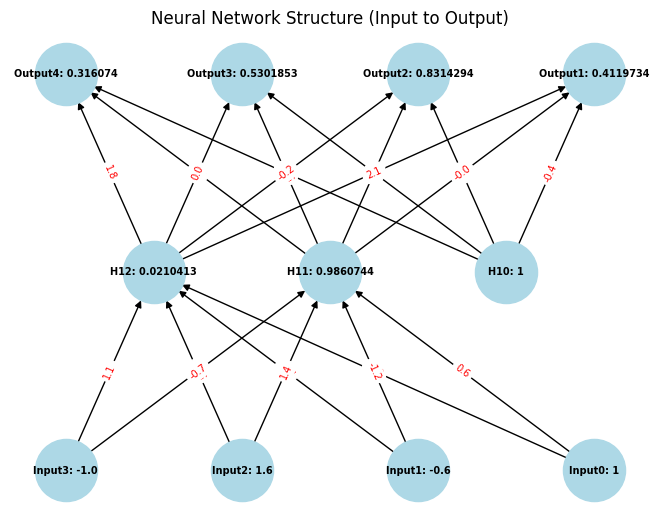

In [15]:
calculateWithoutSavedModel("sigmoid")

    SOFTMAX

Node values:  [[-1.0, 0.5], [0.2592251, 0.7407749]]
output: [[0.2592251, 0.7407749]]
expected output: [[0.2592, 0.7408]]
Edge labels:  {(0, 3): 0.1, (0, 4): 0.2, (1, 3): 0.4, (1, 4): -0.5, (2, 3): 0.7, (2, 4): 0.8}


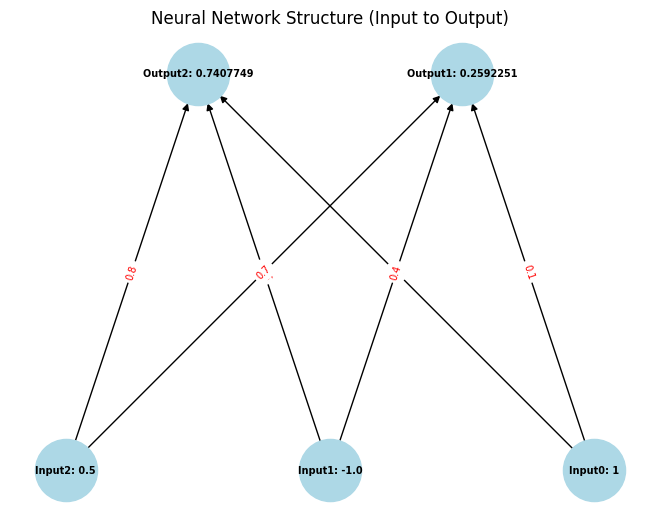

In [16]:
calculateWithoutSavedModel("softmax")

EXAMPLE WITH USING SAVED MODEL

        MULTILAYER

Node values:  [[-1.0, 0.5, 0.8], [2.09, 1.22, 0.25, 0.0], [0.168, 1.708, 0.556], [1.13, 0.2156], [0.4846748]]
output: [[0.4846748]]
expected output: [[0.4846748]]
Edge labels:  {(0, 5): 0.1, (0, 6): 0.2, (0, 7): 0.3, (0, 8): -1.2, (1, 5): -0.5, (1, 6): 0.6, (1, 7): 0.7, (1, 8): 0.5, (2, 5): 0.9, (2, 6): 1.0, (2, 7): -1.1, (2, 8): -1.0, (3, 5): 1.3, (3, 6): 1.4, (3, 7): 1.5, (3, 8): 0.1, (4, 10): 0.1, (4, 11): 0.1, (4, 12): 0.3, (5, 10): -0.4, (5, 11): 0.5, (5, 12): 0.6, (6, 10): 0.7, (6, 11): 0.4, (6, 12): -0.9, (7, 10): 0.2, (7, 11): 0.3, (7, 12): 0.4, (8, 10): -0.1, (8, 11): 0.2, (8, 12): 0.1, (9, 14): 0.1, (9, 15): 0.2, (10, 14): -0.3, (10, 15): 0.4, (11, 14): 0.6, (11, 15): 0.1, (12, 14): 0.1, (12, 15): -0.4, (13, 16): 0.1, (14, 16): -0.2, (15, 16): 0.3}


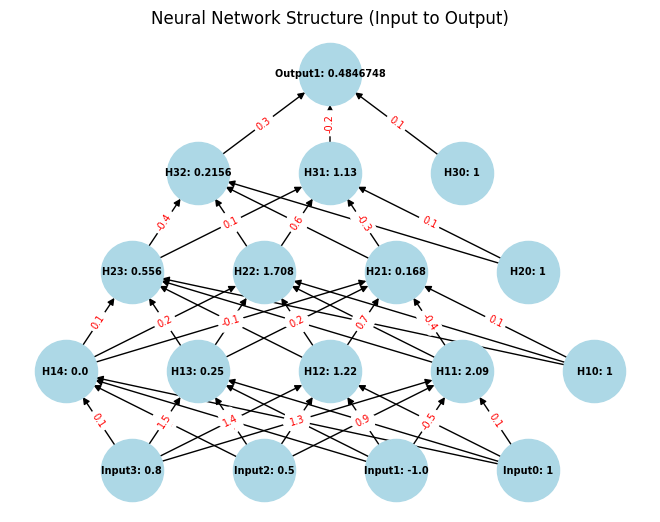

In [17]:
calculateWithSavedModel("multilayer")

SECTION FOR USER INPUTS

In [ ]:
filename = input("Enter model's filename: ")
withOrWithout = input ("Do you want to use saved model? (Y/N): ")

if (withOrWithout.upper() == "Y"):
    calculateWithoutSavedModel(filename)
else:
    calculateWithSavedModel(filename)